In [1]:
import pandas as pd

In [2]:
! unzip './cryptopunks_test_bundle.zip'

Archive:  ./cryptopunks_test_bundle.zip
  inflating: 20230509/eth_usd_fx_rates.csv  
  inflating: 20230509/token_metadata.csv  
  inflating: 20230509/token_sales.csv  


In [178]:
token_meta = pd.read_csv('20230509/token_metadata.csv')
eth_usd_fx_rates = pd.read_csv('20230509/eth_usd_fx_rates.csv')
token_sales = pd.read_csv('20230509/token_sales.csv')

# simple Explore Data Ananlysis

In [11]:
import missingno as msno

<Axes: >

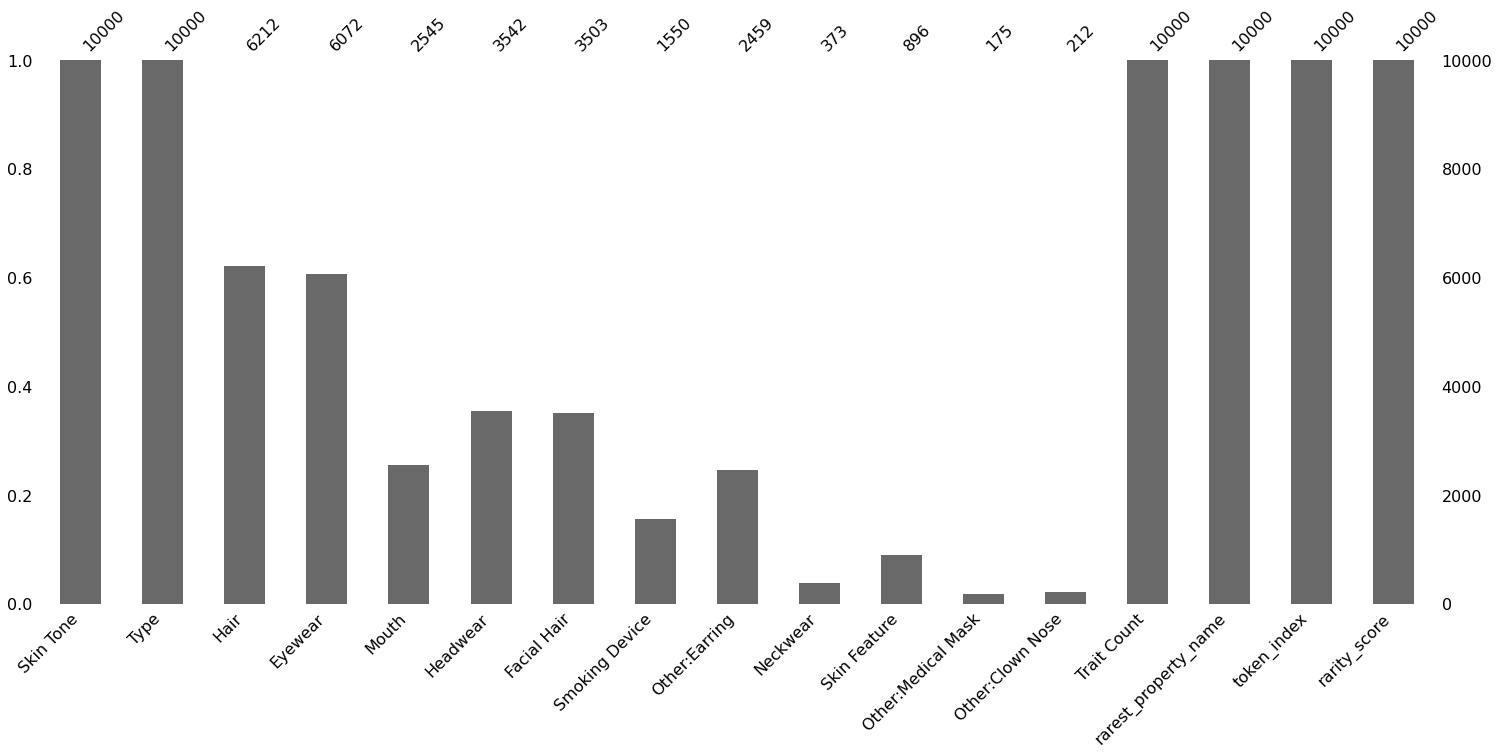

In [12]:
msno.bar(token_meta)

<Axes: >

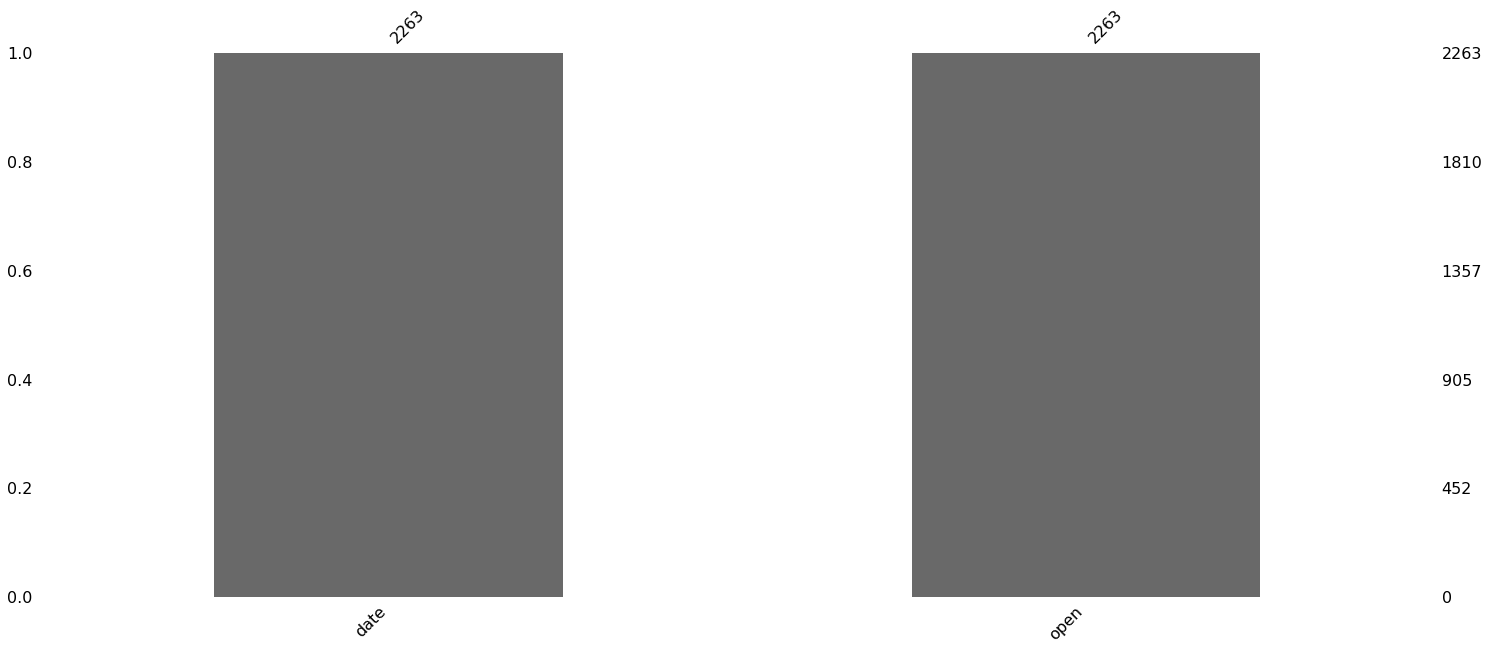

In [13]:
msno.bar(eth_usd_fx_rates)

<Axes: >

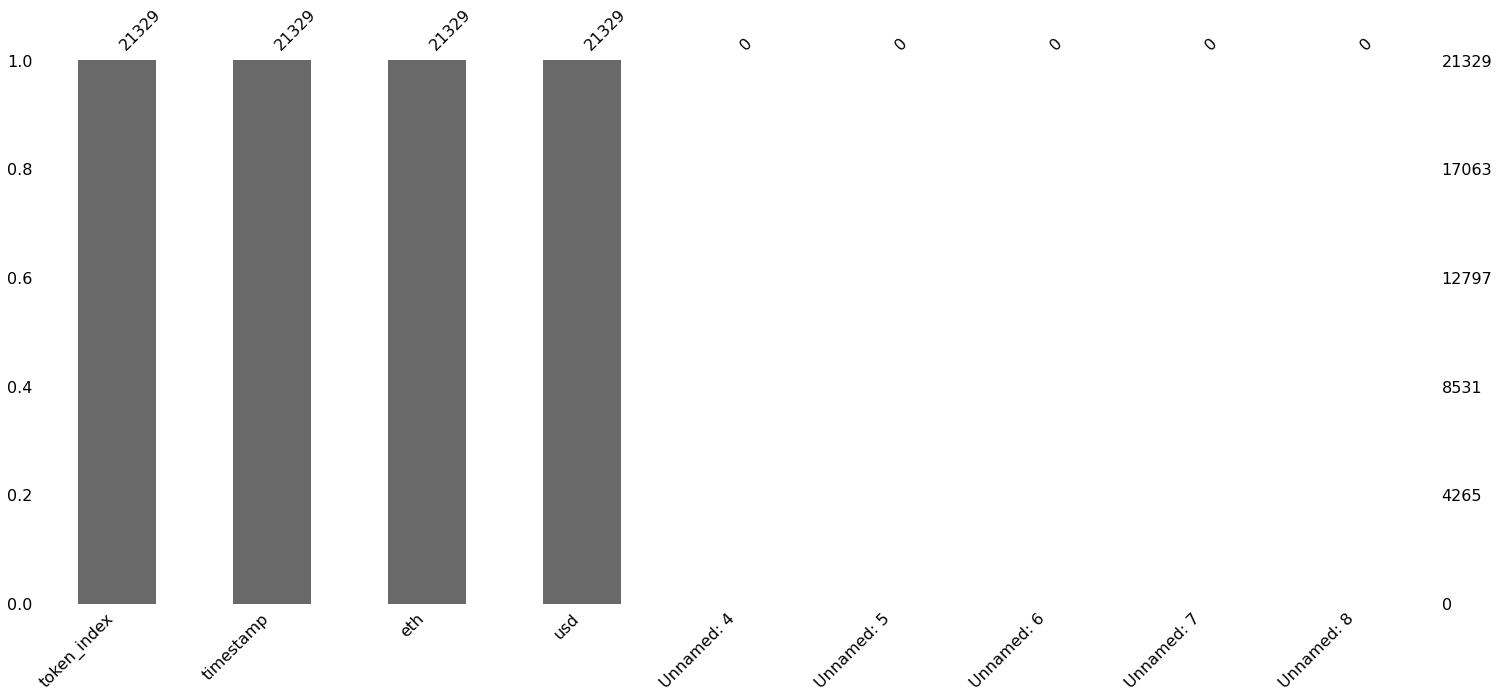

In [14]:
msno.bar(token_sales)

# check some correlations

<Axes: >

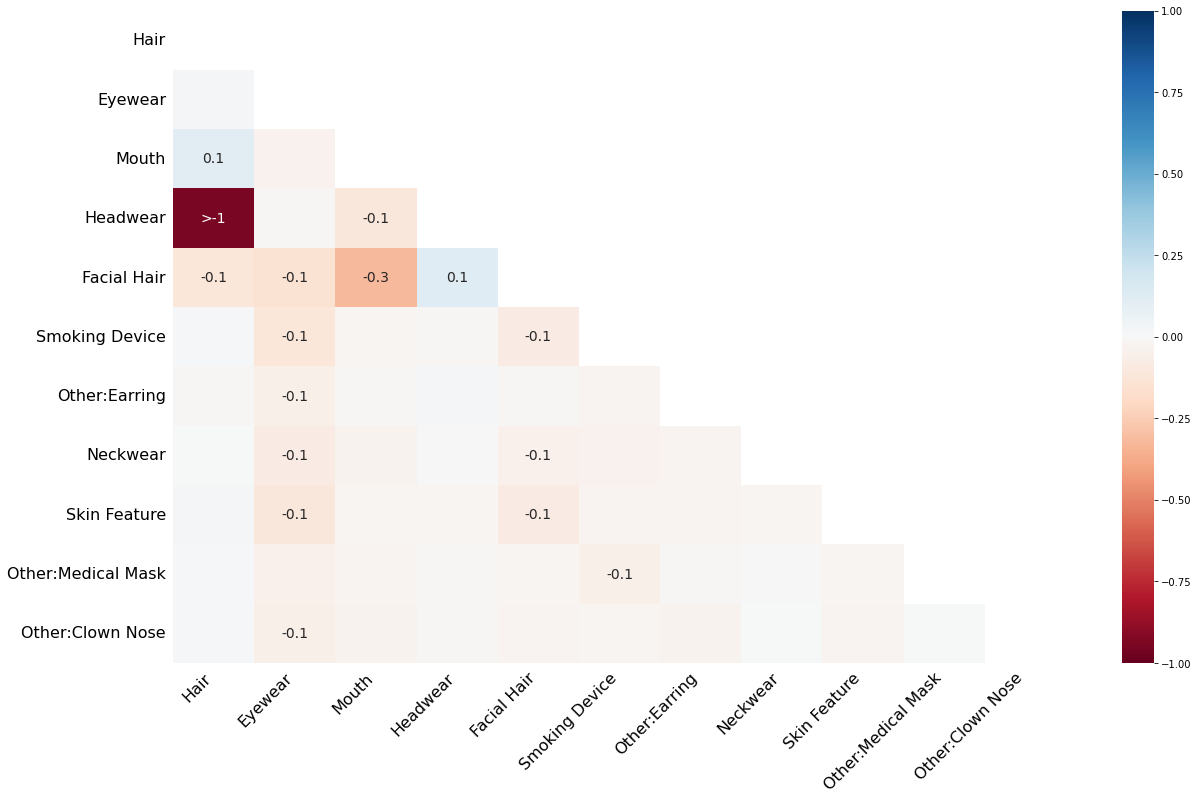

In [15]:
msno.heatmap(token_meta)


# eth and usd is high correlated , lets just use one of them (USD) as target

In [44]:
token_sales[['eth','usd']].corr()

,eth,usd
eth,1.000000,0.935353
usd,0.935353,1.000000


# look at some distributions for categorical features

<Axes: >

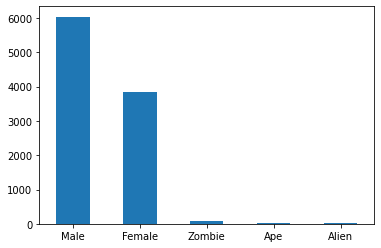

In [29]:
token_meta.Type.value_counts().plot.bar(rot=0)

<Axes: >

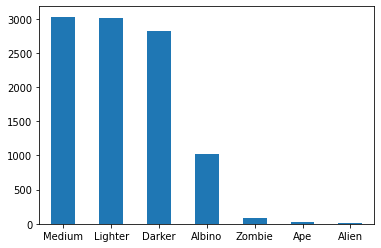

In [30]:
token_meta['Skin Tone'].value_counts().plot.bar(rot=0)

In [33]:
token_meta.Hair.value_counts()

Stringy Hair            463
Messy Hair              460
Wild Hair               447
Frumpy Hair             442
Mohawk Thin             441
Mohawk                  441
Mohawk Dark             429
Crazy Hair              414
Peak Spike              303
Shaved Head             300
Purple Hair             165
Dark Hair               157
Straight Hair           151
Clown Hair Green        148
Straight Hair Dark      148
Vampire Hair            147
Blonde Bob              147
Red Mohawk              147
Half Shaved             147
Straight Hair Blonde    144
Wild Blonde             144
Wild White Hair         136
Blonde Short            129
Pigtails                 94
Orange Side              68
Name: Hair, dtype: int64

# Lets create val set

"your models should be able to adapt to the current market state and not
entirely dependent on last sales recorded."

 to handle this problem, we have to develop low corellated and different val set compare to our train set

1) lets take tokens with high std in sale history

2) lets take low corellated feature vectors from metadata

### Data leak : take only last sale for each token as a target

In [179]:
token_sales['date'] = pd.to_datetime(token_sales.timestamp)

last_dates_for_each_token = token_sales.groupby('token_index')['date'].max().reset_index()

token_sales = token_sales.sort_values(['token_index','date'])

token_sales['id_for_anti_join'] = token_sales['date'].astype(str) + ' ' + token_sales['token_index'].astype(str)

last_dates_for_each_token['id_for_anti_join'] = (last_dates_for_each_token['date'].astype(str)
                                                 + ' ' + last_dates_for_each_token['token_index'].astype(str))

to_drop = last_dates_for_each_token['id_for_anti_join'].values.tolist()

last_dates_for_each_token = (last_dates_for_each_token
                             .merge(
                                 token_sales,
                                 on=['token_index','date'])
                             [['token_index','date', 'usd']]
                            )

In [180]:
token_sales.shape[0] - last_dates_for_each_token.shape[0]

14404

In [181]:
token_sales = token_sales[~token_sales.id_for_anti_join.isin(to_drop)]
token_sales.shape

(14404, 11)

In [182]:
token_sales = token_sales[['token_index','date','usd']]

In [183]:
target = last_dates_for_each_token.copy()

## now we have targets , lets create some new features from history of sales, based on stats

In [184]:
import numpy as np
token_sales = token_sales.groupby(['token_index']).agg(meanUSD = ('usd',np.mean),
                                         medianUSD = ('usd', np.median),
                                        maxUSD = ('usd', np.max),
                                        minUSD = ('usd', np.min),
                                        stdUSD = ('usd', np.std)).reset_index()

#### add rarity and trait 

In [185]:
num_features = token_sales.copy()

num_features = num_features.merge(token_meta[['token_index','rarity_score','Trait Count']], on ='token_index')

num_features['Trait Count'] = num_features['Trait Count'].str.split().apply(lambda x: float(x[0]))

num_features = num_features.astype(float)

In [186]:
num_features

,token_index,meanUSD,medianUSD,maxUSD,minUSD,stdUSD,rarity_score,Trait Count
0,0.0,357.428500,357.42850,394.5440,320.3130,52.489243,117.119410,5.0
1,1.0,2610.730200,2610.73020,5118.7200,102.7404,3546.833189,72.698512,4.0
2,14.0,250.267250,250.26725,315.6655,184.8690,92.487092,239.465714,5.0
3,53.0,35012.350000,35012.35000,43286.1000,26738.6000,11700.849462,93.656590,4.0
4,89.0,2223.885000,2223.88500,4127.4000,320.3700,2691.976729,244.508607,3.0
...,...,...,...,...,...,...,...,...
5053,9979.0,213.310000,213.31000,213.3100,213.3100,NaN,77.313209,6.0
5054,9980.0,80829.971417,74980.22900,181656.2000,70.5890,58306.343895,136.998643,6.0
5055,9982.0,445622.340000,445622.34000,481168.6800,410076.0000,50270.116121,63.938023,5.0
5056,9990.0,45134.880000,45134.88000,45134.8800,45134.8800,NaN,55.655401,4.0


# lets create  features from metadata
#  here is the a lot of categorical data, and looks like this features have  a semantic meaning, so i decided to convert it into sequences of words and vectorize it by using some pretrained Transformers

#### we can use columns like Skin Tone or Type as a main groups , and fill missed data by median or mode from this Groups, but i dont have a enough time to make better feature engineering and decided to move forward without any manipulations 

In [187]:
token_meta = token_meta.fillna('')

In [188]:
token_meta['text'] = (token_meta[['Skin Tone', 'Type', 'Hair', 'Eyewear', 'Mouth', 'Headwear',
       'Facial Hair', 'Smoking Device', 'Other:Earring', 'Neckwear',
       'Skin Feature', 'Other:Medical Mask', 'Other:Clown Nose','rarest_property_name']]
.apply(lambda x : ' '.join(x), axis=1))

token_meta = token_meta[['text','token_index']]

#### delete double spaces from text

In [189]:
import re
def remove_double_space(text: str) -> str:
    """
    This function removes double spaces from input text data
    :param text: str
    :return: str
    """
    return re.sub('\s+', ' ', text)

In [190]:
token_meta['text'] = token_meta['text'].apply(remove_double_space)

#### create vectors/ semantic embeddings from texts

In [191]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device('cpu'))

texts = token_meta.text.values.tolist()

In [193]:
embeddings = model.encode(texts, device = device, batch_size = 128, show_progress_bar=True)

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

#### use cosine similyarity to filter  lowest corellated embeddings from whole corpus

In [194]:
from sentence_transformers import util
from tqdm import tqdm

In [195]:
max_sim_score = []
for embed in tqdm(embeddings):
    all_scores = util.cos_sim(embed, embeddings)
    maximum = all_scores[all_scores<1].max().item()
    max_sim_score.append(maximum)

100%|██████████| 10000/10000 [00:06<00:00, 1617.88it/s]


In [196]:
cat_features = pd.DataFrame(embeddings, columns=[str(f'col{i}') for i in range(384)])

cat_features['token_index'] = token_meta.token_index.values.tolist()

cat_features['max_sim_score'] = max_sim_score

In [198]:
cat_features = cat_features[cat_features.token_index.isin(target.token_index.values.tolist())]
num_features = num_features[num_features.token_index.isin(target.token_index.values.tolist())]

# lets create low corellated validation set

<Axes: >

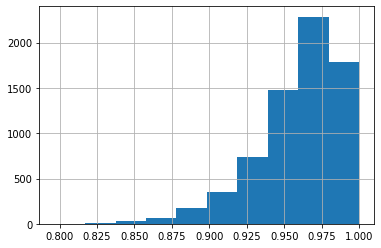

In [200]:
cat_features.max_sim_score.hist()

In [221]:
part1 = cat_features[cat_features.max_sim_score<=0.93].sample(600)
part2 = cat_features[cat_features.max_sim_score>0.93].sample(200)
val_from_cat = pd.concat((part1,part2))

In [205]:
cat_features.shape

(6924, 386)

In [208]:
num_features['std_percent'] = num_features['stdUSD']/num_features['meanUSD']

<Axes: >

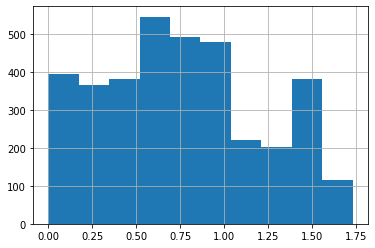

In [215]:
num_features.std_percent.hist()

In [212]:
part1 = num_features[num_features.std_percent>1].sample(600)
part2 = num_features[num_features.std_percent<=1].sample(200)

In [213]:
val_from_num = pd.concat((part1,part2))

In [223]:
setA = set(val_from_cat.token_index.values.tolist())
setB = set(val_from_num.token_index.values.tolist())

In [230]:
val_ids = [i for i in list(setA) if i in list(setB)]

In [245]:
val_num = num_features[num_features.token_index.isin(val_ids)]
train_num = num_features[~num_features.token_index.isin(val_ids)]

val_cat = cat_features[cat_features.token_index.isin(val_ids)]
train_cat = cat_features[~cat_features.token_index.isin(val_ids)]

In [241]:
target = target[['token_index','usd']]

In [246]:
val_num = val_num.merge(target, on='token_index')
train_num = train_num.merge(target, on='token_index')
train_cat = train_cat.merge(target, on='token_index')
val_cat = val_cat.merge(target, on='token_index')

# MODELLING

# lets train 2 diffent regression models and combine them for final prediction

# one based on embeddings from tokem description from metadata

# second - based on statistics from sales history


# METRIC -> MAPE (mean absolute percentage error) , because we have different range of valuation for each token

# dont have time to use Cross validation to find better train test split and for feature selection

# dont have time to use Optuna ot other libs or technics for hyperparameter tuning

In [249]:
from lightgbm import LGBMRegressor

In [252]:
model1 = LGBMRegressor()

In [304]:
X = train_num.drop(['token_index','usd'], axis=1)
y = train_num['usd']

X_val = val_num.drop(['token_index','usd'], axis=1)
y_val = val_num['usd']


In [275]:
model1.fit(X,y)

LGBMRegressor()

In [276]:
preds1 = model1.predict(X_val)

In [258]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [261]:
mape(y_pred=preds, y_true = y_val)

24.966457690350705

In [306]:
gen1 = model1.predict(pd.concat([X, X_val]))

#### second model

In [262]:
model2 = LGBMRegressor()

In [307]:
X = train_cat.drop(['token_index','usd', 'max_sim_score'], axis=1)
y = train_cat['usd']

X_val = val_cat.drop(['token_index','usd', 'max_sim_score'], axis=1)
y_val = val_cat['usd']

In [278]:
model2.fit(X,y)

LGBMRegressor()

In [279]:
preds2 = model2.predict(X_val)

In [273]:
mape(y_pred=preds, y_true = y_val)

115.32552201572827

In [308]:
gen2 = model2.predict(pd.concat([X, X_val]))

## lets use them like both on our VAL SET

In [301]:
final_preds = (0.9 * preds1 + 0.1 * preds2)/2

In [302]:
mape(y_pred=final_preds, y_true = y_val)

17.06178932910493

# MAPE = 17.1 is the final metric for our approach

# score all data

In [ ]:
cat_features['valuation'] = model2.predict(cat_features.drop(['token_index', 'max_sim_score'],axis=1))

In [ ]:
num_features['valuation'] = model1.predict(num_features.drop(['token_index'], axis=1))

In [342]:
part1 = cat_features[['token_index', 'valuation']]
part2 = num_features[['token_index', 'valuation']]

In [343]:
part1.columns = ['token_index', 'valuation1']
part2.columns = ['token_index', 'valuation2']

In [344]:
part2 = part2.merge(part1, on='token_index')
part2['valuation'] = (0.1*part2.valuation1 + 0.9*part2.valuation2)/2

In [348]:
part2[['token_index','valuation']].to_csv('valuations.csv', index = False)